In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import matplotlib
from dataclasses import replace
import time
from datetime import datetime
import pandas as pd
import nlopt
import scipy.special
from matplotlib.colors import LogNorm

In [2]:
import sys
sys.path.append('/home/gridsan/wmichaels/xray_coherence')

from src.simparams import SimParams
from src.threshold_opt import threshold_opt
from src.forwardmodels import forward_model_focus_plane_wave, forward_model_focus_plane_wave_power, forward_model_focus_plane_wave_overlap
from src.elements import ArbitraryElement, ZonePlate
from src.propagation import propagate_z
from src.sources import plane_wave, incoherent_source
from src.inversedesign_utils import heaviside_projection, zp_init
from src.forwardmodels import propagate_z_arbg_z, field_z_arbg_z
from src.util import kramers_law_weights, create_material_map, refractive_index_at_wvl, spherize_1d_array
from src.sparse import matrix_free_eigsh

In [3]:
matplotlib.rcParams['figure.dpi'] = 140
matplotlib.rcParams.update({'font.size': 15})

In [4]:
print(f"cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

cuda available: True
Using device: cuda


In [17]:
sim_params = SimParams(
    Ny=1, 
    Nx=8192, 
    dx=1e-9,
    device=device, 
    dtype = torch.complex64,
    lams=torch.tensor([2e-9]), 
    weights=torch.tensor([1.0])
    )

rsrc = 50e-6
zsrc = 5e-3
Nmodes = 200
sparse_tol = 1e-2

In [22]:
sim_params.weights.shape

torch.Size([1])

In [23]:
torch.cuda.empty_cache()
modes, evals = incoherent_source(sim_params = sim_params, rsrc = rsrc, z = zsrc, N = Nmodes, sparse_tol = sparse_tol)

finished lam 1 of 1


In [24]:
modes.shape

torch.Size([200, 1, 1, 8192])

In [25]:
def circ_mutual_intensity(
    lam, 
    r, 
    z
):
    
    X1, X2 = torch.meshgrid(sim_params.x, sim_params.x, indexing='ij')
    
    DX = (X2 - X1).abs()
    
    k = 2*np.pi / lam
    psi = np.pi / (lam*z)*(X2.abs().pow(2) - X1.abs().pow(2))


    diagonal_mask = torch.eye(DX.shape[0], dtype=bool, device=DX.device)
    DX[diagonal_mask] = 1.0
    
    J = scipy.special.jv(1, DX.cpu().numpy()*k*r/z) / DX.cpu().numpy()*k*r/z
    J = torch.tensor(J, device=device)
    J = torch.exp(-1j*psi)*J
    J /= J.abs().max()
    J.fill_diagonal_(1.)
    return J

In [26]:
J = circ_mutual_intensity(lam = sim_params.lams[0].cpu().numpy(), r = rsrc, z = zsrc)

In [27]:
J.abs().min()

tensor(4.2068e-08, device='cuda:0')

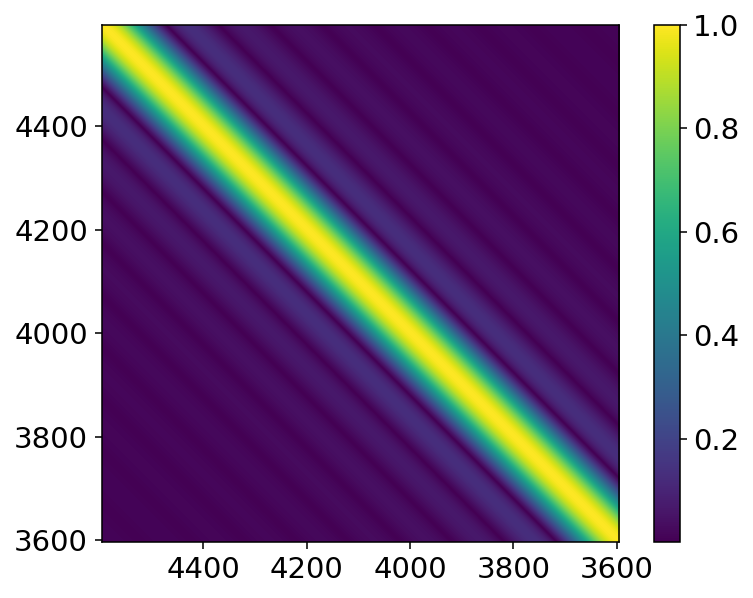

In [34]:
bandwidth = 500
im = plt.imshow(J.cpu().abs())
plt.colorbar(im)
plt.xlim([sim_params.Nx//2+bandwidth,sim_params.Nx//2-bandwidth])
plt.ylim([sim_params.Nx//2-bandwidth,sim_params.Nx//2+bandwidth])
plt.show()

# Source radius

In [29]:
r_list = [10e-6, 20e-6, 50e-6, 100e-6, 500e-6]
eval_list = []
for r in r_list:
    modes, evals = incoherent_source(sim_params = sim_params, rsrc = r, z = zsrc, N = Nmodes, sparse_tol = sparse_tol)
    
    eval_list.append(evals)

finished lam 1 of 1
finished lam 1 of 1
finished lam 1 of 1
finished lam 1 of 1
finished lam 1 of 1


In [30]:
def colors_list(N):
    cmap = plt.colormaps['viridis']
    colors = [cmap(x) for x in np.linspace(0, 1, N)]
    
    return colors

In [31]:
color_list = colors_list(len(eval_list))

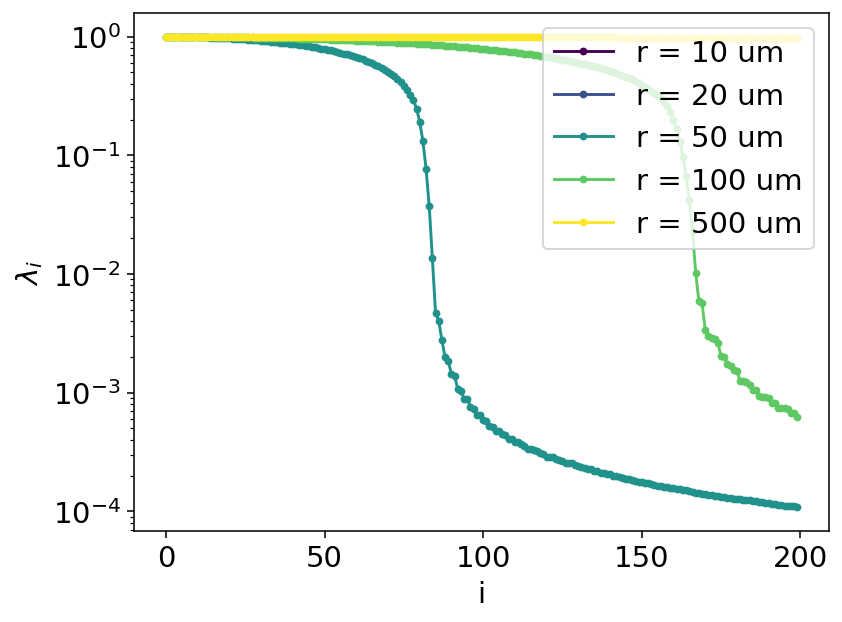

In [32]:
for i, evals in enumerate(eval_list):
    plt.plot(evals.cpu().numpy()[::-1], color=color_list[i], marker='.', label=f"r = {round(r_list[i]*1e6)} um")

plt.xlabel('i')
plt.ylabel("$\\lambda_i$")
plt.semilogy()
plt.legend(loc='upper right')
plt.show()

# Source wavelength

In [ ]:
lam_list = [5e-11, 1e-10, 5e-10, 1e-9, 5e-9]
eval_list = []
for lam in lam_list:
    sim_params = SimParams(
        Ny=1, 
        Nx=4196, 
        dx=1e-9,
        device=device, 
        dtype = torch.complex64,
        lams=torch.tensor([lam]), 
        weights=torch.tensor([1.0])
    )
    modes, evals = incoherent_source(sim_params = sim_params, rsrc = r, z = zsrc, N = Nmodes, sparse_tol = sparse_tol)
    
    eval_list.append(evals)

In [ ]:
color_list = colors_list(len(eval_list))

In [ ]:
for i, evals in enumerate(eval_list):
    if i == 0:
        label = f"$\\lambda$ = {round(lam_list[i]*1e10, 1)} $\AA$"
    else:
        label = f"$\\lambda$ = {round(lam_list[i]*1e10)} $\AA$"
    plt.plot(evals.cpu().numpy()[::-1], color=color_list[i], marker='.', label=label)

plt.xlabel('i')
plt.ylabel("$\\lambda_i$")
plt.semilogy()
plt.legend(loc='upper right')
plt.show()

# Propagation distance

In [ ]:
z_list = [0.5e-3, 1e-3, 5e-3, 10e-3, 50e-3]
eval_list = []
for z in z_list:
    modes, evals = incoherent_source(sim_params = sim_params, rsrc = r, z = z, N = Nmodes, sparse_tol = sparse_tol)
    
    eval_list.append(evals)

In [ ]:
color_list = colors_list(len(eval_list))

In [ ]:
for i, evals in enumerate(eval_list):
    if i == 0:
        label = f"z = {round(z_list[i]*1e3, 1)} mm"
    else:
        label = f"z = {round(z_list[i]*1e3)} mm"
    plt.plot(evals.cpu().numpy()[::-1], color=color_list[i], marker='.', label=label)

plt.xlabel('i')
plt.ylabel("$\\lambda_i$")
plt.semilogy()
plt.legend(loc='upper right')
plt.show()

# Joint wavelength and propagation distance 

In [76]:
cutoff_arr = np.zeros((len(z_list), len(lam_list)))
                    
for i, z in enumerate(z_list):
    print(i)
    for j, lam in enumerate(lam_list):
        
        sim_params = SimParams(
            Ny=1, 
            Nx=4196, 
            dx=1e-9,
            device=device, 
            dtype = torch.complex64,
            lams=torch.tensor([lam]), 
            weights=torch.tensor([1.0])
        )
        
        modes, evals = incoherent_source(sim_params = sim_params, rsrc = rsrc, z = z, N = Nmodes, sparse_tol = sparse_tol)
                      
        cutoff = (evals > 1e-2).sum()
        cutoff_arr[i, j] = cutoff

0
1
2
3
4


RuntimeError: Trying to create tensor with negative dimension -102833234: [2, -102833234]

In [ ]:
cutoff_arr

In [ ]:
extent = [min(lam_list)*1e10, max(lam_list)*1e10, max(z_list)*1e3, min(z_list)*1e3]
im = plt.imshow(cutoff_arr, extent=extent)
plt.colorbar(im)
plt.xlabel('$\\lambda$')
plt.ylabel('z')
plt.show()

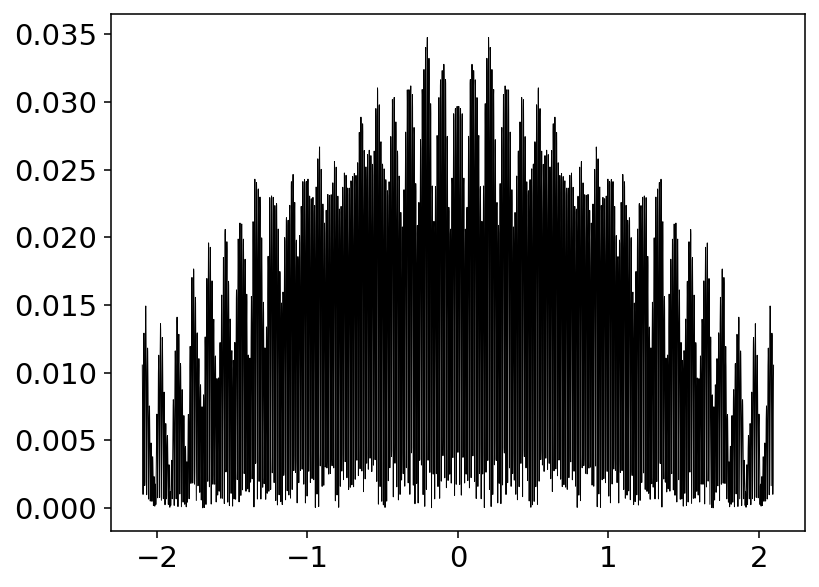

In [126]:
plt.plot(sim_params.x.cpu()*1e6, evecs[:, 0].abs().cpu().numpy(), color='black', linewidth=0.5)
plt.show()